# KMeans Clustering

Process time: 30 seconds aprox.

- Quantilized data already:
    - give us an idea of in what category apps the users stand out the most.
    - can be filtered (with python or a spreadsheet) in order to define some segments, for example:
        - "Music" lovers can be those which have a quantile score greater than 444 (when the number of quantiles is 5).
        - a segment with quantile score > 444 in "Books" and < 444 in "Games".
        - people with quantile score in "Finance": Traffic<3, Duration>4, Frequency>4, use to make money transfers regularly. 
    - can be used for supervised learning using the quantilized columns as features (need to add a label column or target depending on what we want to learn).


- So, why still make clustering? (unsupervised learning):
    - To spot new potential interesting patterns. After grouping we can figure out if there are some relatively big groups of users with similar behaviour (it would be difficult to figure it out manually experimenting with many combinations of filters and counting the resulting number of users for each filtering combination made).
    - is easier to get mutaually exclusive segments. Using only the quanltilized data can give you duplicates among segments (e.g. a user can be "Music" lover but also a "Books" lover, so, to what segment it belongs to?) which is not always a big problem, but that depends on the business needs.
    
If you have very good domain knowledge using the quantilized data can be good enough (your expertise will let you make great filtering combinations and it is likely that you won't get duplicates among segments if that is a problem), and you can make a recipe of the filters to automate the process with python later.

Use clustering if you want to explore more, after all, it is expected that after quantile discretization the clustering results will not be so impressive (or "obscure") compared to the results that an human can give using "spreadsheet filtering" (except that clustering will be faster, which is good).

I mean, the result of clustering quantilized data will be pretty "explainable", so you can explains other what is the algorithm doing. For example you can say: —cluster "x" contains "y%" of all the user base, they love "Music" (>444), have a low frequency of "News" readings (F<3) and a high duration of "Games" (D>4)—.

Good look!

In [1]:
import os
import glob
import time
import json
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import skewnorm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Functions

## Target Users

In [5]:
def target_users_dict(json_file):
    """
    Return the dict of users.
    json_file(json): {"location_1":["user_1", "user_2", ... "user_n"],
                      "location_2":["user_1", "user_2", ... "user_n"] }
    """

    with open(json_file, "rb") as fp:
              data_dict = json.load(fp)
    return data_dict

## Others

In [6]:
def read_ConfigFile(file):
    import json
    with open(file, 'rb' ) as f:
        json_str = json.load(f)
    return json_str

# Main Program

In [7]:
ConfigFile = read_ConfigFile("ConfigFile.json")

In [8]:
print("SCRIPT 1 - Feature Engineering")
print()

print("ConfigFile Parameters: ")
for param, value in ConfigFile.items():
    print(param, " : ", value)

SCRIPT 1 - Feature Engineering

ConfigFile Parameters: 
innactive_time_between_app_session_in_seconds  :  60
sampling_period_in_hours  :  6
number_of_quantiles  :  5
potential_high_value_users_file  :  0_potential_high_value_users.json
category_apps_dictionary_file  :  all_category_apps_dictionary.json
country  :  China
final_report_folder_name  :  report_Dec2021


In [9]:
# ConfigFile parameters
innactive_time_between_app_session_in_seconds = ConfigFile['innactive_time_between_app_session_in_seconds']
sampling_period_in_hours = ConfigFile['sampling_period_in_hours']
number_of_quantiles = ConfigFile['number_of_quantiles']
potential_high_value_users_file = ConfigFile['potential_high_value_users_file']
category_apps_dictionary_file = ConfigFile['category_apps_dictionary_file']
country = ConfigFile['country']
final_report_folder_name = ConfigFile['final_report_folder_name']

In [10]:
report_directory = f"data/2_reports/S{sampling_period_in_hours}Q{number_of_quantiles}_{final_report_folder_name}/"

In [11]:
report_directory

'data/2_reports/S6Q5_report_Dec2021/'

In [12]:
quantilized_data = pd.read_csv(report_directory + f'QUANTILIZED_table_wide_format_S{sampling_period_in_hours}Q{number_of_quantiles}.csv',
                               sep=',',
                               encoding='utf-8',
                              )

In [13]:
quantilized_data

,user_id,traffic_bytes,duration_sec,frequency,T,D,F,TDF_Score,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports,country,city
0,942,3.743837e+10,12523302.0,474051.0,5,5,5,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,China,big_chinese_city
1,772,8.505699e+09,1893671.0,82460.0,5,5,5,555,555,0,555,555,555,555,454,555,555,555,555,555,555,555,555,555,555,555,541,555,China,big_chinese_city
2,837,2.954388e+09,843211.0,44828.0,5,5,5,555,555,0,554,555,555,555,223,555,555,555,555,555,555,555,555,555,555,555,0,555,China,big_chinese_city
3,723,2.199940e+09,718885.0,31017.0,5,5,5,555,555,0,321,555,555,555,0,555,555,555,555,555,555,555,555,555,555,555,221,555,China,big_chinese_city
4,667,1.974879e+09,447621.0,22576.0,5,5,5,555,555,0,555,555,555,555,354,555,555,555,555,334,555,555,555,555,555,555,0,455,China,big_chinese_city
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,578,8.754400e+04,373.0,31.0,1,1,1,111,0,0,0,111,0,111,0,111,0,111,111,0,0,0,111,0,111,0,0,0,China,big_chinese_city
867,468,8.129800e+04,20.0,16.0,1,1,1,111,0,0,0,0,0,111,0,111,0,111,0,0,0,0,111,0,111,0,0,0,China,big_chinese_city
868,252,2.192800e+04,18.0,10.0,1,1,1,111,0,0,0,0,0,0,0,111,0,111,111,0,0,0,111,0,111,0,0,0,China,big_chinese_city
869,295,2.086200e+04,22.0,13.0,1,1,1,111,0,0,0,0,0,0,0,0,0,111,0,0,0,0,111,0,111,0,0,0,China,big_chinese_city


In [14]:
# columns to delete
searchfor = ["country", "city"]
# searchfor = ["traffic_bytes", "duration_sec", "frequency", "TDF_Score", "country", "city"]
origin_cols = pd.Series(quantilized_data.columns)
columns_to_delete = origin_cols[origin_cols.str.contains("|".join(searchfor))]
columns_to_delete

28    country
29       city
dtype: object

In [15]:
quantilized_data = quantilized_data.drop(columns=columns_to_delete)

In [16]:
quantilized_data

,user_id,traffic_bytes,duration_sec,frequency,T,D,F,TDF_Score,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
0,942,3.743837e+10,12523302.0,474051.0,5,5,5,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555
1,772,8.505699e+09,1893671.0,82460.0,5,5,5,555,555,0,555,555,555,555,454,555,555,555,555,555,555,555,555,555,555,555,541,555
2,837,2.954388e+09,843211.0,44828.0,5,5,5,555,555,0,554,555,555,555,223,555,555,555,555,555,555,555,555,555,555,555,0,555
3,723,2.199940e+09,718885.0,31017.0,5,5,5,555,555,0,321,555,555,555,0,555,555,555,555,555,555,555,555,555,555,555,221,555
4,667,1.974879e+09,447621.0,22576.0,5,5,5,555,555,0,555,555,555,555,354,555,555,555,555,334,555,555,555,555,555,555,0,455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,578,8.754400e+04,373.0,31.0,1,1,1,111,0,0,0,111,0,111,0,111,0,111,111,0,0,0,111,0,111,0,0,0
867,468,8.129800e+04,20.0,16.0,1,1,1,111,0,0,0,0,0,111,0,111,0,111,0,0,0,0,111,0,111,0,0,0
868,252,2.192800e+04,18.0,10.0,1,1,1,111,0,0,0,0,0,0,0,111,0,111,111,0,0,0,111,0,111,0,0,0
869,295,2.086200e+04,22.0,13.0,1,1,1,111,0,0,0,0,0,0,0,0,0,111,0,0,0,0,111,0,111,0,0,0


In [17]:
# columns to keep (optional)
select_only_some_columns = True

if select_only_some_columns:
    searchfor=["user_id",	
#                 "T",	
#                 "D",	
#                 "F",	
#                 "TDF_Score", 
#                 "traffic_bytes", 
#                 "duration_sec", 
#                 "frequency",
                "Books",	
                "Business",	
                "Education",	
                "Entertainment",	
                "Finance",	
                "Games",	
                "Health&Fitness",	
                "Lifestyle",	
                "Music",	
                "Navigation",	
                "News",	
                "Photo&Video",	
                "References",	
                "Shopping",	
                "Social_Networking",	
                "Travel",	
                "Utilities",	
                "Weather",	
                "infant&mom",	
                "sports"]
    origin_cols = pd.Series(quantilized_data.columns)
    columns_to_keep = origin_cols[origin_cols.str.contains("|".join(searchfor))]
    quantilized_data = quantilized_data[columns_to_keep.to_list()]
quantilized_data

,user_id,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
0,942,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555
1,772,555,0,555,555,555,555,454,555,555,555,555,555,555,555,555,555,555,555,541,555
2,837,555,0,554,555,555,555,223,555,555,555,555,555,555,555,555,555,555,555,0,555
3,723,555,0,321,555,555,555,0,555,555,555,555,555,555,555,555,555,555,555,221,555
4,667,555,0,555,555,555,555,354,555,555,555,555,334,555,555,555,555,555,555,0,455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,578,0,0,0,111,0,111,0,111,0,111,111,0,0,0,111,0,111,0,0,0
867,468,0,0,0,0,0,111,0,111,0,111,0,0,0,0,111,0,111,0,0,0
868,252,0,0,0,0,0,0,0,111,0,111,111,0,0,0,111,0,111,0,0,0
869,295,0,0,0,0,0,0,0,0,0,111,0,0,0,0,111,0,111,0,0,0


In [18]:
quantilized_data = quantilized_data.set_index('user_id')

In [19]:
quantilized_data

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
user_id,,,,,,,,,,,,,,,,,,,,
942,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555
772,555,0,555,555,555,555,454,555,555,555,555,555,555,555,555,555,555,555,541,555
837,555,0,554,555,555,555,223,555,555,555,555,555,555,555,555,555,555,555,0,555
723,555,0,321,555,555,555,0,555,555,555,555,555,555,555,555,555,555,555,221,555
667,555,0,555,555,555,555,354,555,555,555,555,334,555,555,555,555,555,555,0,455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,0,0,111,0,111,0,111,0,111,111,0,0,0,111,0,111,0,0,0
468,0,0,0,0,0,111,0,111,0,111,0,0,0,0,111,0,111,0,0,0
252,0,0,0,0,0,0,0,111,0,111,111,0,0,0,111,0,111,0,0,0


In [20]:
quantilized_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 942 to 137
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Books              871 non-null    int64
 1   Business           871 non-null    int64
 2   Education          871 non-null    int64
 3   Entertainment      871 non-null    int64
 4   Finance            871 non-null    int64
 5   Games              871 non-null    int64
 6   Health&Fitness     871 non-null    int64
 7   Lifestyle          871 non-null    int64
 8   Music              871 non-null    int64
 9   Navigation         871 non-null    int64
 10  News               871 non-null    int64
 11  Photo&Video        871 non-null    int64
 12  References         871 non-null    int64
 13  Shopping           871 non-null    int64
 14  Social_Networking  871 non-null    int64
 15  Travel             871 non-null    int64
 16  Utilities          871 non-null    int64
 17  Weather       

In [21]:
quantilized_data = quantilized_data.fillna(0.0)

In [22]:
quantilized_data.describe()

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
count,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000
mean,204.540758,2.676234,28.801378,304.029851,209.704937,328.788749,11.466131,328.018370,296.391504,332.743972,323.803674,105.226177,167.455798,249.190586,332.745121,271.396096,332.617681,139.673938,11.087256,152.163031
std,202.419691,33.617912,103.598555,174.607617,202.326222,158.244112,67.109353,158.669872,179.422956,154.030173,162.014486,177.684204,199.210459,197.164295,154.870088,190.743537,154.112445,192.392987,66.408449,196.009221
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000,0.000000,0.000000,0.000000,0.000000,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,122.000000,0.000000,221.000000,0.000000,213.000000,117.000000,221.000000,212.000000,0.000000,0.000000,0.000000,221.000000,111.000000,221.000000,0.000000,0.000000,0.000000
50%,122.000000,0.000000,0.000000,332.000000,211.000000,333.000000,0.000000,333.000000,323.000000,333.000000,333.000000,0.000000,111.000000,224.000000,333.000000,233.000000,333.000000,0.000000,0.000000,0.000000
75%,353.000000,0.000000,0.000000,445.000000,421.000000,449.000000,0.000000,445.000000,444.000000,448.500000,445.000000,211.000000,334.000000,443.000000,445.000000,444.000000,445.000000,311.000000,0.000000,323.000000
max,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


In [23]:
categories_frequencies_dict = {}
for col in quantilized_data:
    mask = quantilized_data[col] > 0.0
    print(f"{col}: {mask.sum()}")
    categories_frequencies_dict[col] = mask.sum()

Books: 535
Business: 7
Education: 76
Entertainment: 796
Finance: 549
Games: 860
Health&Fitness : 30
Lifestyle : 858
Music: 776
Navigation: 871
News: 847
Photo&Video: 276
References : 438
Shopping: 652
Social_Networking: 871
Travel: 710
Utilities: 870
Weather: 366
infant&mom: 29
sports: 398


In [24]:
pd.Series(categories_frequencies_dict).sort_values(ascending=False)

Navigation           871
Social_Networking    871
Utilities            870
Games                860
Lifestyle            858
News                 847
Entertainment        796
Music                776
Travel               710
Shopping             652
Finance              549
Books                535
References           438
sports               398
Weather              366
Photo&Video          276
Education             76
Health&Fitness        30
infant&mom            29
Business               7
dtype: int64

# Distributions

<AxesSubplot:xlabel='Books', ylabel='Count'>

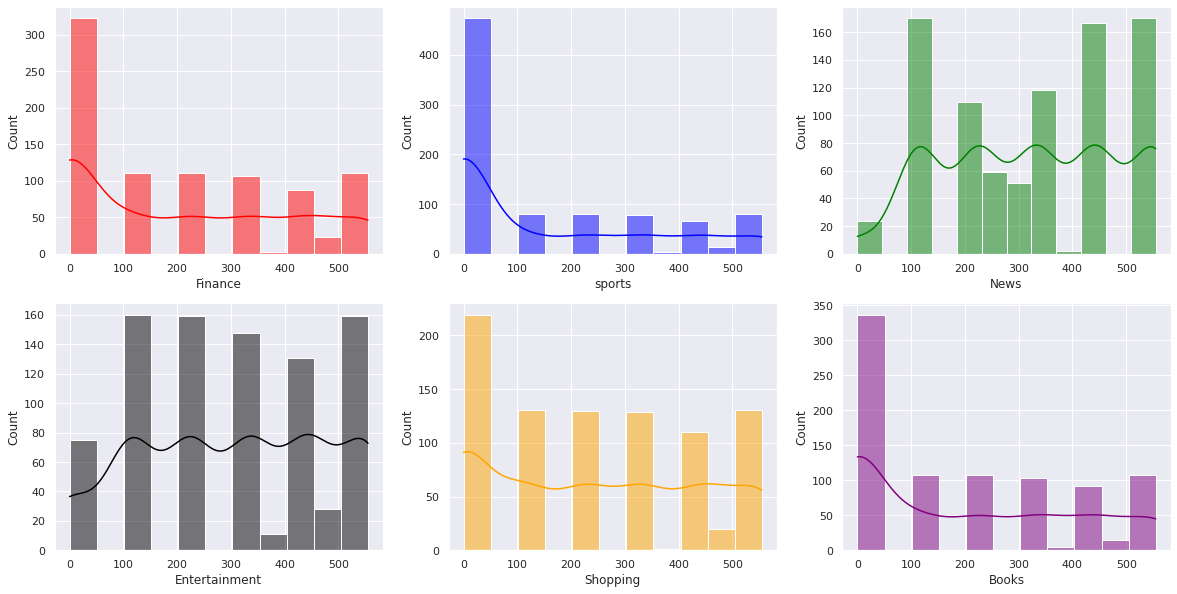

In [25]:
df = quantilized_data
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.histplot(df['Finance'],ax=ax[0,0], color='red',   kde='True')
sns.histplot(df['sports'], ax=ax[0,1], color='blue',  kde='True')
sns.histplot(df['News'],   ax=ax[0,2], color='green', kde='True')
sns.histplot(df['Entertainment'], ax=ax[1,0], color='black',  kde='True')
sns.histplot(df['Shopping'],      ax=ax[1,1], color='orange', kde='True')
sns.histplot(df['Books'],         ax=ax[1,2], color='purple',   kde='True')

In [26]:
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
X_quantile_trans = quantile_transformer.fit_transform(quantilized_data)

In [27]:
X_quantile_trans = pd.DataFrame(X_quantile_trans, columns=quantilized_data.columns)

<AxesSubplot:xlabel='Books', ylabel='Count'>

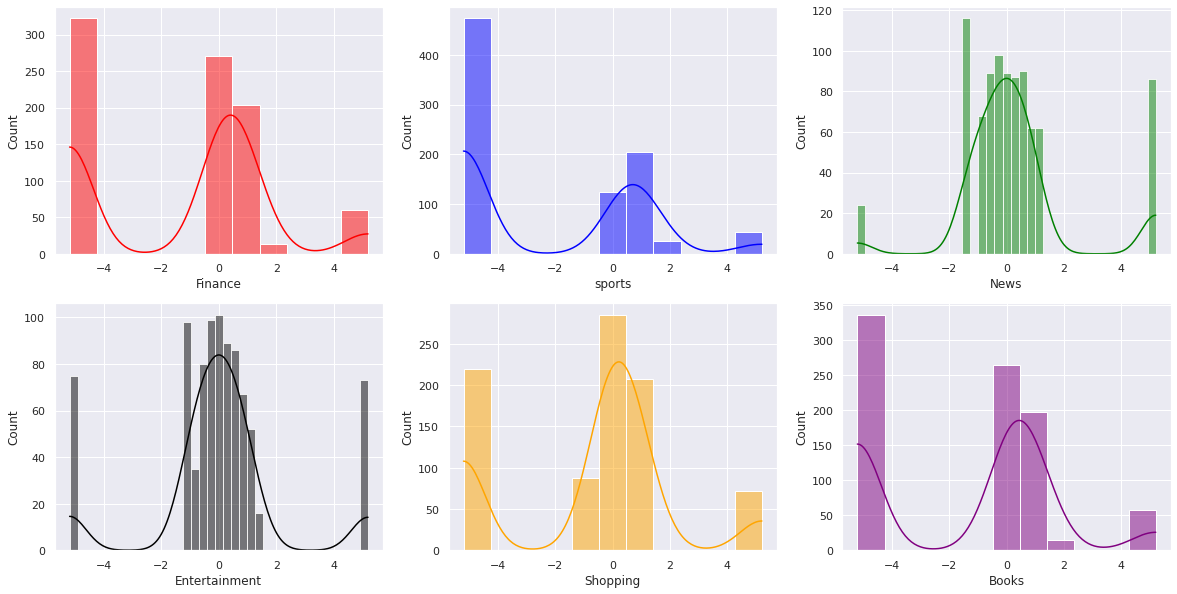

In [28]:
df = X_quantile_trans
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.histplot(df['Finance'],ax=ax[0,0], color='red',   kde='True')
sns.histplot(df['sports'], ax=ax[0,1], color='blue',  kde='True')
sns.histplot(df['News'],   ax=ax[0,2], color='green', kde='True')
sns.histplot(df['Entertainment'], ax=ax[1,0], color='black',  kde='True')
sns.histplot(df['Shopping'],      ax=ax[1,1], color='orange', kde='True')
sns.histplot(df['Books'],         ax=ax[1,2], color='purple',   kde='True')

In [29]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer( standardize=False, method='yeo-johnson')
power_transformer = pt.fit_transform(quantilized_data)

In [30]:
X_power_transformer = pd.DataFrame(power_transformer, columns=quantilized_data.columns)

<AxesSubplot:xlabel='Books', ylabel='Count'>

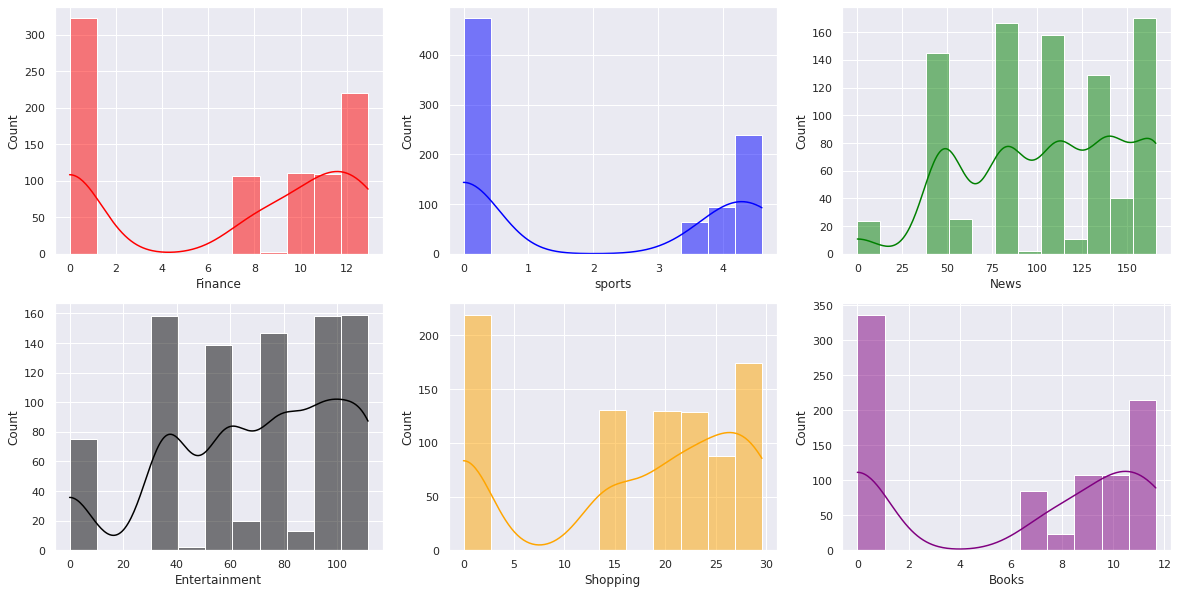

In [31]:
df = X_power_transformer
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.histplot(df['Finance'],ax=ax[0,0], color='red',   kde='True')
sns.histplot(df['sports'], ax=ax[0,1], color='blue',  kde='True')
sns.histplot(df['News'],   ax=ax[0,2], color='green', kde='True')
sns.histplot(df['Entertainment'], ax=ax[1,0], color='black',  kde='True')
sns.histplot(df['Shopping'],      ax=ax[1,1], color='orange', kde='True')
sns.histplot(df['Books'],         ax=ax[1,2], color='purple',   kde='True')

# K-Means Clustering

In [32]:
import sklearn
sklearn.__version__

'0.24.1'

In [33]:
from sklearn.cluster  import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

## Preprocessing

- Important
    - Don't use scalling if the variables have same units and are juxtaposted features (e.g. comparing left arm with the right arm).
    - Use scalling when the features have different scales.

In [34]:
X = quantilized_data.copy() 
# X = X_quantile_trans.copy()
# X = X_power_transformer.copy()


In [35]:
use_scaling = True

if use_scaling:
    X = quantilized_data.copy()
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
user_id,,,,,,,,,,,,,,,,,,,,
942,1.732344,16.438888,5.082126,1.438164,1.707606,1.430329,8.103880,1.431349,1.442163,1.443767,1.427830,2.532764,1.946519,1.551930,1.435930,1.487688,1.443816,2.159978,8.195121,2.056375
772,1.732344,-0.079653,5.082126,1.438164,1.707606,1.430329,6.598009,1.431349,1.442163,1.443767,1.427830,2.532764,1.946519,1.551930,1.435930,1.487688,1.443816,2.159978,7.984183,2.056375
837,1.732344,-0.079653,5.072468,1.438164,1.707606,1.430329,3.153888,1.431349,1.442163,1.443767,1.427830,2.532764,1.946519,1.551930,1.435930,1.487688,1.443816,2.159978,-0.167051,2.056375
723,1.732344,-0.079653,2.822110,1.438164,1.707606,1.430329,-0.170956,1.431349,1.442163,1.443767,1.427830,2.532764,1.946519,1.551930,1.435930,1.487688,1.443816,2.159978,3.162750,2.056375
667,1.732344,-0.079653,5.082126,1.438164,1.707606,1.430329,5.107048,1.431349,1.442163,1.443767,1.427830,1.288270,1.946519,1.551930,1.435930,1.487688,1.443816,2.159978,-0.167051,1.545902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,-1.011059,-0.079653,-0.278169,-1.106142,-1.037065,-1.377074,-0.170956,-1.368521,-1.652864,-1.440441,-1.314240,-0.592549,-0.841080,-1.264599,-1.432636,-1.423650,-1.438852,-0.726400,-0.167051,-0.776751
468,-1.011059,-0.079653,-0.278169,-1.742218,-1.037065,-1.377074,-0.170956,-1.368521,-1.652864,-1.440441,-1.999758,-0.592549,-0.841080,-1.264599,-1.432636,-1.423650,-1.438852,-0.726400,-0.167051,-0.776751
252,-1.011059,-0.079653,-0.278169,-1.742218,-1.037065,-2.078925,-0.170956,-1.368521,-1.652864,-1.440441,-1.314240,-0.592549,-0.841080,-1.264599,-1.432636,-1.423650,-1.438852,-0.726400,-0.167051,-0.776751


# PCA (Principal Component Analysis)

In [36]:
from sklearn.decomposition import PCA

In [37]:
%%time
pca = PCA(random_state=123).fit(X)
X_projected = pca.transform(X)

CPU times: user 45.9 ms, sys: 21.2 ms, total: 67.1 ms
Wall time: 13 ms


In [38]:
# our new projcted data
pd.DataFrame(X_projected)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9.081432,18.384022,3.973630,0.180344,0.586923,5.351544,2.765438,-0.077616,-0.315763,0.431774,0.284778,-1.189086,0.425824,0.103992,-0.091399,-0.291849,-0.000935,0.216067,-0.024475,-0.169665
1,8.112885,7.990582,0.145568,-3.437561,-0.493530,-5.137700,-1.650877,-0.423718,2.202502,0.093403,1.242552,-1.119571,0.239153,-0.009626,-0.242006,-0.568629,-0.064315,-0.067872,-0.220815,-0.244395
2,7.301198,2.173927,-2.549884,-3.587727,-1.280189,0.148251,-0.788890,-0.601416,-0.311304,0.035871,0.854963,-0.681766,0.240751,0.439187,0.185041,-0.246701,-0.180531,0.010746,-0.329291,-0.164814
3,6.944694,2.000762,-0.930506,0.668901,-2.284631,-1.852694,-0.843082,-0.138564,0.521680,0.317519,0.522932,-0.642964,0.255449,0.186439,0.093420,0.047909,-0.096930,0.010962,-0.170541,-0.123970
4,7.102348,2.848403,-1.928018,-5.256066,-0.251156,-0.157809,-0.490471,-0.766216,-0.479165,-0.048353,0.504718,-0.229102,-0.123336,0.089563,0.064989,-0.045269,-0.129082,-0.090892,-0.277066,-0.113701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,-4.780891,0.517019,-0.413252,-0.095225,-0.150637,-0.008996,0.098091,-0.093553,0.159463,-0.013280,0.294679,0.011106,0.184893,0.369496,0.153553,0.193335,-0.056668,-0.089491,0.001331,-0.054582
867,-5.092256,0.603331,-0.681007,-0.130135,-0.173369,0.056254,0.167992,0.172290,0.485590,0.107047,0.114746,0.031231,0.187494,0.465980,-0.154701,0.343593,0.488033,0.074096,0.105939,-0.098736
868,-5.107851,0.610513,-0.604598,-0.140003,-0.209815,0.000988,0.162785,0.057238,0.335580,0.303884,0.288739,0.326943,0.387910,0.232150,0.322953,0.069770,0.045160,0.386098,0.349793,-0.192345
869,-5.466359,0.768676,-0.931725,-0.014758,-0.151033,-0.040038,0.151921,-0.095872,0.257770,0.110057,0.381809,0.379634,0.391065,0.110208,0.169068,0.114471,0.744689,0.183193,0.183855,-0.156560


In [39]:
# printing the PCs
df_components = pd.DataFrame(pca.components_)
df_components.index = list(X.columns)
df_components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Books,0.212642,0.050085,0.127091,0.216946,0.247709,0.269239,0.084868,0.264495,0.262698,0.276486,0.252905,0.214879,0.246676,0.243791,0.288272,0.257848,0.277813,0.184915,0.063569,0.192807
Business,0.063450,0.585878,0.293558,-0.007918,0.063417,-0.126034,0.398902,-0.109844,-0.044077,-0.115984,-0.118561,0.037494,0.061378,0.013094,-0.100557,-0.039339,-0.134201,0.005709,0.544697,0.119140
Education,-0.269275,0.228214,-0.212852,0.113813,-0.145587,0.169483,-0.008125,0.188245,-0.106450,0.265778,0.284983,-0.385818,-0.294515,-0.082554,0.128872,-0.083542,0.298128,-0.063720,0.334366,-0.312737
Entertainment,0.144249,0.275592,-0.470606,0.143446,0.061597,-0.066203,-0.662414,-0.098451,0.057301,-0.046688,-0.082175,0.241547,0.066701,0.024783,-0.012057,0.031068,-0.041218,-0.135275,0.298868,0.135933
Finance,0.207780,0.014968,-0.615945,0.089402,-0.060183,0.003292,0.573637,-0.035210,0.002197,0.011711,-0.049795,0.014729,0.028035,0.042204,0.041447,0.085578,0.020831,-0.426697,-0.145140,0.131430
Games,-0.035412,0.653632,0.183049,-0.125156,-0.063185,0.099202,-0.120679,0.038098,0.086242,0.035447,0.020946,0.112394,0.014633,-0.083257,0.070885,-0.023574,0.082400,-0.276290,-0.597711,-0.132724
Health&Fitness,-0.143495,0.256050,-0.441713,-0.131174,0.060300,0.026704,0.147476,-0.003817,-0.011707,-0.066446,0.019746,0.065366,0.117432,-0.050120,-0.069430,0.090165,-0.142399,0.743805,-0.167539,-0.188039
Lifestyle,-0.403562,0.024334,-0.083517,-0.461251,0.206628,0.203178,-0.042688,0.179383,0.097804,-0.070579,0.040186,-0.181034,-0.086642,-0.147913,-0.048950,0.211895,-0.053685,-0.098083,0.039936,0.599273
Music,-0.076846,-0.161402,-0.036654,-0.513599,-0.011594,0.214535,0.058443,0.110360,0.083699,-0.010041,0.000819,0.423110,0.279218,-0.091439,0.027962,0.030619,-0.011208,-0.237040,0.283745,-0.479755
Navigation,0.696943,0.024309,-0.018705,-0.479526,-0.104930,-0.017310,-0.045645,0.013057,-0.095030,0.077643,0.269414,-0.058715,-0.254230,-0.184990,0.049497,-0.173506,0.064364,0.157349,0.026366,0.133136


In [40]:
# Explained variance per component
number_of_components = len(np.round(pca.explained_variance_ratio_*100, 2))
print("n_components: ", number_of_components)
np.round(pca.explained_variance_ratio_*100, 2)

n_components:  20


array([46.78,  6.75,  5.18,  4.73,  4.  ,  3.76,  3.48,  3.36,  3.17,
        2.64,  2.46,  2.29,  2.03,  1.89,  1.75,  1.61,  1.54,  1.05,
        0.88,  0.65])

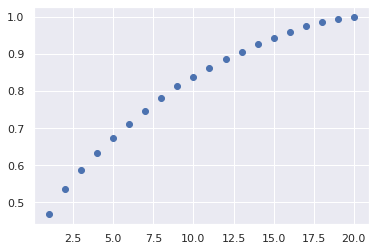

In [41]:
plt.scatter(x=range(1, number_of_components + 1), y=np.cumsum(pca.explained_variance_ratio_))

In [42]:
# Exploring PCs
n_component = 0
for cum_variance_ratio in np.cumsum(pca.explained_variance_ratio_):
    print(f"Component number: {n_component} --> variance ration accumulated: {cum_variance_ratio}")
    n_component += 1

Component number: 0 --> variance ration accumulated: 0.46783982607283203
Component number: 1 --> variance ration accumulated: 0.5353717107252627
Component number: 2 --> variance ration accumulated: 0.5871859759784785
Component number: 3 --> variance ration accumulated: 0.6344892141584547
Component number: 4 --> variance ration accumulated: 0.674495168766648
Component number: 5 --> variance ration accumulated: 0.7121127835569605
Component number: 6 --> variance ration accumulated: 0.7469136222310369
Component number: 7 --> variance ration accumulated: 0.7805256051459227
Component number: 8 --> variance ration accumulated: 0.8122402415498402
Component number: 9 --> variance ration accumulated: 0.8386433219366
Component number: 10 --> variance ration accumulated: 0.8632152918154914
Component number: 11 --> variance ration accumulated: 0.8860840012001079
Component number: 12 --> variance ration accumulated: 0.9063868937452038
Component number: 13 --> variance ration accumulated: 0.92533262

In [43]:
# filter noise and improve training time
n_component = 0
variance_ratio_accumulated_threeshold = 0.999

for cum_variance_ratio in np.cumsum(pca.explained_variance_ratio_):
    print(f"Component number: {n_component} --> variance ration accumulated: {cum_variance_ratio}")
    n_component += 1
    
    if cum_variance_ratio >= variance_ratio_accumulated_threeshold:
        print()
        print(f"{n_component} principal components describe {round(cum_variance_ratio, 6)*100} % of the data.")
        break

Component number: 0 --> variance ration accumulated: 0.46783982607283203
Component number: 1 --> variance ration accumulated: 0.5353717107252627
Component number: 2 --> variance ration accumulated: 0.5871859759784785
Component number: 3 --> variance ration accumulated: 0.6344892141584547
Component number: 4 --> variance ration accumulated: 0.674495168766648
Component number: 5 --> variance ration accumulated: 0.7121127835569605
Component number: 6 --> variance ration accumulated: 0.7469136222310369
Component number: 7 --> variance ration accumulated: 0.7805256051459227
Component number: 8 --> variance ration accumulated: 0.8122402415498402
Component number: 9 --> variance ration accumulated: 0.8386433219366
Component number: 10 --> variance ration accumulated: 0.8632152918154914
Component number: 11 --> variance ration accumulated: 0.8860840012001079
Component number: 12 --> variance ration accumulated: 0.9063868937452038
Component number: 13 --> variance ration accumulated: 0.92533262

In [44]:
X_reduced = pd.DataFrame(X_projected[:, 0:n_component+1])
X_reduced.index = X.index
X_reduced

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
user_id,,,,,,,,,,,,,,,,,,,,
942,9.081432,18.384022,3.973630,0.180344,0.586923,5.351544,2.765438,-0.077616,-0.315763,0.431774,0.284778,-1.189086,0.425824,0.103992,-0.091399,-0.291849,-0.000935,0.216067,-0.024475,-0.169665
772,8.112885,7.990582,0.145568,-3.437561,-0.493530,-5.137700,-1.650877,-0.423718,2.202502,0.093403,1.242552,-1.119571,0.239153,-0.009626,-0.242006,-0.568629,-0.064315,-0.067872,-0.220815,-0.244395
837,7.301198,2.173927,-2.549884,-3.587727,-1.280189,0.148251,-0.788890,-0.601416,-0.311304,0.035871,0.854963,-0.681766,0.240751,0.439187,0.185041,-0.246701,-0.180531,0.010746,-0.329291,-0.164814
723,6.944694,2.000762,-0.930506,0.668901,-2.284631,-1.852694,-0.843082,-0.138564,0.521680,0.317519,0.522932,-0.642964,0.255449,0.186439,0.093420,0.047909,-0.096930,0.010962,-0.170541,-0.123970
667,7.102348,2.848403,-1.928018,-5.256066,-0.251156,-0.157809,-0.490471,-0.766216,-0.479165,-0.048353,0.504718,-0.229102,-0.123336,0.089563,0.064989,-0.045269,-0.129082,-0.090892,-0.277066,-0.113701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,-4.780891,0.517019,-0.413252,-0.095225,-0.150637,-0.008996,0.098091,-0.093553,0.159463,-0.013280,0.294679,0.011106,0.184893,0.369496,0.153553,0.193335,-0.056668,-0.089491,0.001331,-0.054582
468,-5.092256,0.603331,-0.681007,-0.130135,-0.173369,0.056254,0.167992,0.172290,0.485590,0.107047,0.114746,0.031231,0.187494,0.465980,-0.154701,0.343593,0.488033,0.074096,0.105939,-0.098736
252,-5.107851,0.610513,-0.604598,-0.140003,-0.209815,0.000988,0.162785,0.057238,0.335580,0.303884,0.288739,0.326943,0.387910,0.232150,0.322953,0.069770,0.045160,0.386098,0.349793,-0.192345


# >>> hyperparameters <<<

In [45]:
%%time
use_principal_components = True
use_minibatches = True

#  >>> hyperparameters <<<
n_init_       = 10
max_iter_     = 300
random_state_ = 42
n_jobs_       = -1

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.5 µs


# Inercia

In [46]:
if use_principal_components == True:
    if use_minibatches == True:
        kmeans_per_k = [MiniBatchKMeans(n_clusters=k, n_init=n_init_, max_iter=max_iter_, random_state=random_state_, verbose=1).fit(X_reduced) for k in range(1, 30)]
        inertias = [model.inertia_ for model in kmeans_per_k]
    elif use_minibatches == False:
        kmeans_per_k = [KMeans(n_clusters=k, n_init=n_init_, max_iter=max_iter_, random_state=random_state_, verbose=1).fit(X_reduced) for k in range(1, 30)]
        inertias = [model.inertia_ for model in kmeans_per_k]
        
elif use_principal_components == False:
    if use_minibatches == True:
        kmeans_per_k = [MiniBatchKMeans(n_clusters=k, n_init=n_init_, max_iter=max_iter_, random_state=random_state_, verbose=1).fit(X) for k in range(1, 30)]
        inertias = [model.inertia_ for model in kmeans_per_k]
    elif use_minibatches == False:
        kmeans_per_k = [KMeans(n_clusters=k, n_init=n_init_, max_iter=max_iter_, random_state=random_state_, verbose=1).fit(X) for k in range(1, 30)]
        inertias = [model.inertia_ for model in kmeans_per_k]       
        

Init 1/10 with method: k-means++
Inertia for init 1/10: 5628.169148
Init 2/10 with method: k-means++
Inertia for init 2/10: 5628.169148
Init 3/10 with method: k-means++
Inertia for init 3/10: 5628.169148
Init 4/10 with method: k-means++
Inertia for init 4/10: 5628.169148
Init 5/10 with method: k-means++
Inertia for init 5/10: 5628.169148
Init 6/10 with method: k-means++
Inertia for init 6/10: 5628.169148
Init 7/10 with method: k-means++
Inertia for init 7/10: 5628.169148
Init 8/10 with method: k-means++
Inertia for init 8/10: 5628.169148
Init 9/10 with method: k-means++
Inertia for init 9/10: 5628.169148
Init 10/10 with method: k-means++
Inertia for init 10/10: 5628.169148
Minibatch iteration 1/2700: mean batch inertia: 18.600976, ewa inertia: 18.600976 
Minibatch iteration 2/2700: mean batch inertia: 23.325508, ewa inertia: 19.684585 
Minibatch iteration 3/2700: mean batch inertia: 16.617096, ewa inertia: 18.981032 
Minibatch iteration 4/2700: mean batch inertia: 21.994687, ewa inerti

In [47]:
inertias

[17457.329088243045,
 11475.907487416542,
 10173.996390927297,
 9530.114092242668,
 9159.684255994245,
 8992.453235957802,
 8096.677389194082,
 8014.185763602067,
 7126.269260134925,
 7548.218363746449,
 7392.044452805721,
 6628.8212345426045,
 6623.607844231188,
 6373.847406966517,
 6299.801646954384,
 6210.42416451301,
 6290.2914005363045,
 6600.4257735386645,
 5985.247126042869,
 6002.034946769041,
 5830.682987799279,
 6000.551198962682,
 5713.500617898251,
 5678.931914575926,
 5523.1174177810935,
 5527.611090133588,
 5409.2428960990665,
 5462.117464208958,
 5275.911577805017]

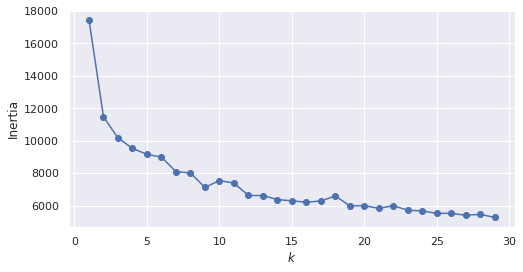

In [48]:
# elbow graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, 30), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show()

# Silhoutte Score

In [49]:
%%time
if use_principal_components == True:
    silhouette_scores = [silhouette_score(X_reduced, model.labels_, n_jobs=-1, random_state=123) for model in kmeans_per_k[1:]]
if use_principal_components == False:
    silhouette_scores = [silhouette_score(X, model.labels_, n_jobs=-1, random_state=123) for model in kmeans_per_k[1:]]    

CPU times: user 8.99 s, sys: 9.48 s, total: 18.5 s
Wall time: 3.09 s


In [50]:
kmeans_per_k[1:]

[MiniBatchKMeans(max_iter=300, n_clusters=2, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=3, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=4, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=5, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=6, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=7, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_init=10, random_state=42, verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=9, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=10, n_init=10, random_state=42,
                 verbose=1),
 MiniBatchKMeans(max_iter=300, n_clusters=11, n_init=10, random_state=42,
                 verbose=1),
 MiniBatc

In [51]:
silhouette_scores

[0.31916406039395,
 0.19604791195913798,
 0.1949342353568451,
 0.17675895153200313,
 0.1301687264680359,
 0.1663476765849508,
 0.11524313702615109,
 0.1457852029834414,
 0.13660593127976298,
 0.11450878020418898,
 0.128451217725574,
 0.12568585064680327,
 0.12684977000702152,
 0.11840738792691191,
 0.11857564603777936,
 0.11258270924399467,
 0.09274025142223073,
 0.09773153572641828,
 0.09299162015246047,
 0.11025658252594123,
 0.1015397205480807,
 0.10812947960957868,
 0.0862805978392218,
 0.09354133280255153,
 0.1083626839759889,
 0.09176225025324496,
 0.08030573694606793,
 0.09815628679058891]

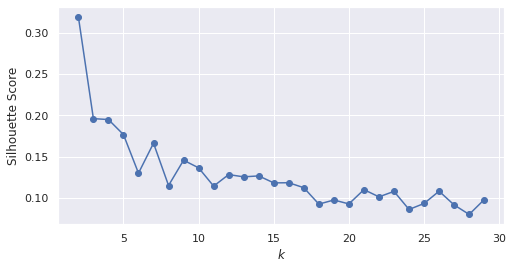

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 30), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette Score")
plt.show()

# Tunning

Choose the best "k" previous calculated and label the dataset  using the best model found ( or the k that produces interesting clusters in the "relative importance" chart)

In [53]:
best_k = 25
best_clustering_model = kmeans_per_k[1:][best_k - 2]
print(best_clustering_model)
predictions = best_clustering_model.fit_predict(X)

MiniBatchKMeans(max_iter=300, n_clusters=25, n_init=10, random_state=42,
                verbose=1)
Init 1/10 with method: k-means++
Inertia for init 1/10: 1751.221973
Init 2/10 with method: k-means++
Inertia for init 2/10: 1872.003253
Init 3/10 with method: k-means++
Inertia for init 3/10: 1919.335997
Init 4/10 with method: k-means++
Inertia for init 4/10: 1735.845531
Init 5/10 with method: k-means++
Inertia for init 5/10: 1849.235353
Init 6/10 with method: k-means++
Inertia for init 6/10: 1731.185969
Init 7/10 with method: k-means++
Inertia for init 7/10: 1763.160767
Init 8/10 with method: k-means++
Inertia for init 8/10: 1723.709408
Init 9/10 with method: k-means++
Inertia for init 9/10: 1936.853975
Init 10/10 with method: k-means++
Inertia for init 10/10: 1852.291586
Minibatch iteration 1/2700: mean batch inertia: 6.555123, ewa inertia: 6.555123 
Minibatch iteration 2/2700: mean batch inertia: 7.000658, ewa inertia: 6.657310 
Minibatch iteration 3/2700: mean batch inertia: 6.247696

In [54]:
pd.Series(predictions).value_counts()

10    94
0     77
4     70
19    64
3     47
1     46
17    46
11    44
9     37
22    36
21    35
15    35
24    35
6     31
5     30
7     29
14    25
2     20
13    19
20    14
23    13
16    12
18     6
8      5
12     1
dtype: int64

In [55]:
quantilized_data['cluster'] = predictions

In [56]:
quantilized_data

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
942,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,8
772,555,0,555,555,555,555,454,555,555,555,555,555,555,555,555,555,555,555,541,555,12
837,555,0,554,555,555,555,223,555,555,555,555,555,555,555,555,555,555,555,0,555,18
723,555,0,321,555,555,555,0,555,555,555,555,555,555,555,555,555,555,555,221,555,7
667,555,0,555,555,555,555,354,555,555,555,555,334,555,555,555,555,555,555,0,455,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,0,0,111,0,111,0,111,0,111,111,0,0,0,111,0,111,0,0,0,10
468,0,0,0,0,0,111,0,111,0,111,0,0,0,0,111,0,111,0,0,0,10
252,0,0,0,0,0,0,0,111,0,111,111,0,0,0,111,0,111,0,0,0,10


# Summary statistics of each cluster

In [57]:
quantilized_data['cluster'].value_counts()

10    94
0     77
4     70
19    64
3     47
1     46
17    46
11    44
9     37
22    36
21    35
15    35
24    35
6     31
5     30
7     29
14    25
2     20
13    19
20    14
23    13
16    12
18     6
8      5
12     1
Name: cluster, dtype: int64

In [58]:
quantilized_data.groupby('cluster').agg({'sum'})

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
cluster,,,,,,,,,,,,,,,,,,,,
0,2788,0,125,5882,1110,15575,0,15565,6297,13532,14941,911,1235,5770,12637,6029,11379,4399,0,445
1,20664,0,566,19068,19515,22437,0,22037,23606,22733,19417,22858,19294,20185,23722,22093,22074,4023,0,14910
2,9212,0,0,8741,6441,6768,0,6982,7100,8503,9409,334,1456,4194,7796,5860,8424,2473,0,942
3,8838,0,0,14600,3766,11082,0,12179,13111,15643,18729,1874,3046,10217,15315,4379,16187,1923,0,1463
4,29254,0,1346,35291,32218,36014,344,36378,34456,36249,36398,15848,27007,34283,37284,34488,36977,27855,0,27166
5,6770,112,242,8814,7783,11350,112,10247,11287,9706,10801,3679,7142,11402,11248,10113,9622,12529,0,3485
6,9840,0,212,9892,7987,11628,0,9937,12246,11044,9483,10196,10282,8976,12175,12785,10122,1223,223,9516
7,12462,111,11627,13081,13570,15083,111,15263,14753,14784,14031,8756,12009,14226,15096,14186,14872,10403,221,9249


In [59]:
quantilized_data.groupby('cluster').agg({'mean'})

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,,,,,,,,,,
0,36.207792,0.000000,1.623377,76.389610,14.415584,202.272727,0.000000,202.142857,81.779221,175.740260,194.038961,11.831169,16.038961,74.935065,164.116883,78.298701,147.779221,57.129870,0.000000,5.779221
1,449.217391,0.000000,12.304348,414.521739,424.239130,487.760870,0.000000,479.065217,513.173913,494.195652,422.108696,496.913043,419.434783,438.804348,515.695652,480.282609,479.869565,87.456522,0.000000,324.130435
2,460.600000,0.000000,0.000000,437.050000,322.050000,338.400000,0.000000,349.100000,355.000000,425.150000,470.450000,16.700000,72.800000,209.700000,389.800000,293.000000,421.200000,123.650000,0.000000,47.100000
3,188.042553,0.000000,0.000000,310.638298,80.127660,235.787234,0.000000,259.127660,278.957447,332.829787,398.489362,39.872340,64.808511,217.382979,325.851064,93.170213,344.404255,40.914894,0.000000,31.127660
4,417.914286,0.000000,19.228571,504.157143,460.257143,514.485714,4.914286,519.685714,492.228571,517.842857,519.971429,226.400000,385.814286,489.757143,532.628571,492.685714,528.242857,397.928571,0.000000,388.085714
5,225.666667,3.733333,8.066667,293.800000,259.433333,378.333333,3.733333,341.566667,376.233333,323.533333,360.033333,122.633333,238.066667,380.066667,374.933333,337.100000,320.733333,417.633333,0.000000,116.166667
6,317.419355,0.000000,6.838710,319.096774,257.645161,375.096774,0.000000,320.548387,395.032258,356.258065,305.903226,328.903226,331.677419,289.548387,392.741935,412.419355,326.516129,39.451613,7.193548,306.967742
7,429.724138,3.827586,400.931034,451.068966,467.931034,520.103448,3.827586,526.310345,508.724138,509.793103,483.827586,301.931034,414.103448,490.551724,520.551724,489.172414,512.827586,358.724138,7.620690,318.931034


In [60]:
quantilized_data.groupby('cluster').agg({'median'})

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median
cluster,,,,,,,,,,,,,,,,,,,,
0,0.0,0,0.0,111.0,0.0,212.0,0.0,213.0,0.0,133.0,211.0,0.0,0.0,0.0,122.0,0.0,113.0,0.0,0,0.0
1,445.0,0,0.0,444.0,444.0,499.5,0.0,449.5,555.0,522.0,434.0,543.0,449.0,444.5,554.0,543.5,455.0,0.0,0,334.0
2,549.5,0,0.0,449.5,328.0,333.0,0.0,427.0,388.5,443.0,455.0,0.0,0.0,227.5,344.5,277.0,444.0,111.0,0,0.0
3,122.0,0,0.0,332.0,0.0,222.0,0.0,321.0,311.0,333.0,421.0,0.0,0.0,223.0,323.0,111.0,333.0,0.0,0,0.0
4,444.0,0,0.0,544.0,449.5,554.0,0.0,555.0,544.0,554.5,554.5,222.0,423.0,544.0,555.0,545.0,555.0,443.5,0,434.0
5,217.5,0,0.0,278.0,227.0,338.5,0.0,338.5,338.5,332.5,334.0,111.0,228.0,438.5,339.0,333.5,332.5,434.0,0,111.0
6,334.0,0,0.0,332.0,232.0,343.0,0.0,332.0,423.0,334.0,322.0,332.0,345.0,322.0,423.0,435.0,334.0,0.0,0,334.0
7,445.0,0,411.0,455.0,454.0,555.0,0.0,555.0,555.0,554.0,455.0,333.0,454.0,545.0,555.0,554.0,555.0,434.0,0,333.0


# Relative Importance of Features

In [61]:
cluster_distribution = quantilized_data['cluster'].value_counts()

# Kurtosis and  Skewness

In [62]:
# distribution characteristics

def identify_asymmetric_distribution_shape(df, column):
    
    """Calculate skewness and kurtosis of the cluster distribution"""
    
    Skewness = df[column].value_counts().skew()
    Kurtosis = df[column].value_counts().kurtosis()
    
    if Skewness > 0:
        print("Positive Skewness: ", Skewness)
        if Skewness > 1:
            print("It is very skewned!")
        elif Skewness <= 0.5:
            print("Pretty bell shaped!")
    elif Skewness < 0:
        print("Negative Skewness", Skewness)
        if Skewness < -1:
            print("It is very skewed!")
        elif Skewness >= -0.5:
            print("Pretty bell shaped!")  


    if Kurtosis > 0:
        print("Positive Kurtosis: ", Kurtosis)
        if Kurtosis > 1:
            print("It has a big peak!")
        elif Kurtosis <= 0.5:
            print("Pretty bell shaped!")
    elif Kurtosis < 0:
        print("Negative Kurtosis", Kurtosis)            
        if Kurtosis < -1:
            print("It is very flat!")
        elif Kurtosis >= -0.5:
            print("Pretty bell shaped!")
    else:
        print(Kurtosis)

In [63]:
identify_asymmetric_distribution_shape(quantilized_data, 'cluster')
print()
print(cluster_distribution)

Positive Skewness:  0.8331645791334116
Positive Kurtosis:  0.603538595774384

10    94
0     77
4     70
19    64
3     47
1     46
17    46
11    44
9     37
22    36
21    35
15    35
24    35
6     31
5     30
7     29
14    25
2     20
13    19
20    14
23    13
16    12
18     6
8      5
12     1
Name: cluster, dtype: int64


In [64]:
def subset_by_iqr(df, column, whisker_with=1.5):
    """
    Remove ourliers from a dataframe by column, including
    optional whiskers removing rows for which the column value are
    less than Q1-1.5IQR or greater than Q3+1.5IQR.
    """
    
    q1  = df[column].quantile(.25)
    q3  = df[column].quantile(.90) 
    iqr = q3 - q1  
    
    filter_ = (df[column]>=(q1-whisker_with*iqr)) & (df[column]<=(q3+whisker_with*iqr))
    
    return df.loc[filter_]

In [65]:
selected_clusters_to_analize = subset_by_iqr(cluster_distribution.to_frame(), column='cluster', whisker_with=1.5)
selected_clusters_to_analize

,cluster
10,94
0,77
4,70
19,64
3,47
1,46
17,46
11,44
9,37
22,36


In [66]:
selected_clusters_to_analize = list(selected_clusters_to_analize.index)
selected_clusters_to_analize

[10,
 0,
 4,
 19,
 3,
 1,
 17,
 11,
 9,
 22,
 21,
 15,
 24,
 6,
 5,
 7,
 14,
 2,
 13,
 20,
 23,
 16,
 18,
 8,
 12]

In [67]:
mask = quantilized_data['cluster'].isin(selected_clusters_to_analize)
clustering_data_selected_clusters = quantilized_data[mask]
clustering_data_selected_clusters

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
942,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,8
772,555,0,555,555,555,555,454,555,555,555,555,555,555,555,555,555,555,555,541,555,12
837,555,0,554,555,555,555,223,555,555,555,555,555,555,555,555,555,555,555,0,555,18
723,555,0,321,555,555,555,0,555,555,555,555,555,555,555,555,555,555,555,221,555,7
667,555,0,555,555,555,555,354,555,555,555,555,334,555,555,555,555,555,555,0,455,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,0,0,111,0,111,0,111,0,111,111,0,0,0,111,0,111,0,0,0,10
468,0,0,0,0,0,111,0,111,0,111,0,0,0,0,111,0,111,0,0,0,10
252,0,0,0,0,0,0,0,111,0,111,111,0,0,0,111,0,111,0,0,0,10


In [68]:
cluster_avg = clustering_data_selected_clusters.groupby('cluster').mean()
cluster_avg

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
cluster,,,,,,,,,,,,,,,,,,,,
0,36.207792,0.000000,1.623377,76.389610,14.415584,202.272727,0.000000,202.142857,81.779221,175.740260,194.038961,11.831169,16.038961,74.935065,164.116883,78.298701,147.779221,57.129870,0.000000,5.779221
1,449.217391,0.000000,12.304348,414.521739,424.239130,487.760870,0.000000,479.065217,513.173913,494.195652,422.108696,496.913043,419.434783,438.804348,515.695652,480.282609,479.869565,87.456522,0.000000,324.130435
2,460.600000,0.000000,0.000000,437.050000,322.050000,338.400000,0.000000,349.100000,355.000000,425.150000,470.450000,16.700000,72.800000,209.700000,389.800000,293.000000,421.200000,123.650000,0.000000,47.100000
3,188.042553,0.000000,0.000000,310.638298,80.127660,235.787234,0.000000,259.127660,278.957447,332.829787,398.489362,39.872340,64.808511,217.382979,325.851064,93.170213,344.404255,40.914894,0.000000,31.127660
4,417.914286,0.000000,19.228571,504.157143,460.257143,514.485714,4.914286,519.685714,492.228571,517.842857,519.971429,226.400000,385.814286,489.757143,532.628571,492.685714,528.242857,397.928571,0.000000,388.085714
5,225.666667,3.733333,8.066667,293.800000,259.433333,378.333333,3.733333,341.566667,376.233333,323.533333,360.033333,122.633333,238.066667,380.066667,374.933333,337.100000,320.733333,417.633333,0.000000,116.166667
6,317.419355,0.000000,6.838710,319.096774,257.645161,375.096774,0.000000,320.548387,395.032258,356.258065,305.903226,328.903226,331.677419,289.548387,392.741935,412.419355,326.516129,39.451613,7.193548,306.967742
7,429.724138,3.827586,400.931034,451.068966,467.931034,520.103448,3.827586,526.310345,508.724138,509.793103,483.827586,301.931034,414.103448,490.551724,520.551724,489.172414,512.827586,358.724138,7.620690,318.931034
8,439.600000,421.600000,160.000000,552.800000,546.000000,508.200000,111.000000,488.200000,532.600000,508.600000,510.600000,370.600000,428.200000,482.000000,530.600000,486.200000,530.400000,244.200000,219.800000,441.600000


In [69]:
population_avg = clustering_data_selected_clusters.mean()
population_avg

Books                204.540758
Business               2.676234
Education             28.801378
Entertainment        304.029851
Finance              209.704937
Games                328.788749
Health&Fitness        11.466131
Lifestyle            328.018370
Music                296.391504
Navigation           332.743972
News                 323.803674
Photo&Video          105.226177
References           167.455798
Shopping             249.190586
Social_Networking    332.745121
Travel               271.396096
Utilities            332.617681
Weather              139.673938
infant&mom            11.087256
sports               152.163031
cluster               10.586682
dtype: float64

In [70]:
relative_importance = cluster_avg  / population_avg - 1

In [71]:
relative_importance

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,cluster,infant&mom,sports
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.822980,-1.000000,-0.943635,-0.748743,-0.931258,-0.384794,-1.000000,-0.383745,-0.724084,-0.471845,-0.400751,-0.887564,-0.904220,-0.699286,-0.506779,-0.711497,-0.555708,-0.590977,NaN,-1.000000,-0.962020
1,1.196224,-1.000000,-0.572786,0.363424,1.023029,0.483508,-1.000000,0.460483,0.731406,0.485213,0.303595,3.722333,1.504749,0.760919,0.549822,0.769674,0.442706,-0.373852,NaN,-1.000000,1.130152
2,1.251874,-1.000000,-1.000000,0.437523,0.535729,0.029232,-1.000000,0.064270,0.197740,0.277709,0.452887,-0.841294,-0.565258,-0.158475,0.171467,0.079603,0.266319,-0.114724,NaN,-1.000000,-0.690464
3,-0.080660,-1.000000,-1.000000,0.021736,-0.617903,-0.282861,-1.000000,-0.210021,-0.058821,0.000258,0.230651,-0.621080,-0.612981,-0.127644,-0.020719,-0.656700,0.035436,-0.707069,NaN,-1.000000,-0.795432
4,1.043183,-1.000000,-0.332373,0.658249,1.194784,0.564791,-0.571409,0.584319,0.660738,0.556280,0.605823,1.151556,1.303977,0.965392,0.600710,0.815375,0.588138,1.848982,NaN,-1.000000,1.550460
5,0.103285,0.394995,-0.719921,-0.033648,0.237135,0.150688,-0.674403,0.041303,0.269380,-0.027681,0.111888,0.165426,0.421669,0.525205,0.126788,0.242096,-0.035730,1.990059,NaN,-1.000000,-0.236564
6,0.551864,-1.000000,-0.762556,0.049557,0.228608,0.140844,-1.000000,-0.022773,0.332806,0.070667,-0.055282,2.125679,0.980686,0.161956,0.180309,0.519622,-0.018344,-0.717545,NaN,-0.351188,1.017361
7,1.100922,0.430213,12.920551,0.483634,1.231378,0.581877,-0.666183,0.604515,0.716392,0.532088,0.494200,1.869353,1.472912,0.968580,0.564416,0.802430,0.541793,1.568297,NaN,-0.312662,1.095982
8,1.149205,156.534792,4.555290,0.818243,1.603658,0.545673,8.680685,0.488331,0.796948,0.528503,0.576881,2.521937,1.557093,0.934262,0.594614,0.791477,0.594624,0.748358,NaN,18.824562,1.902150


In [72]:
relative_importance = relative_importance.drop(columns=['cluster'])
relative_importance

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports
cluster,,,,,,,,,,,,,,,,,,,,
0,-0.822980,-1.000000,-0.943635,-0.748743,-0.931258,-0.384794,-1.000000,-0.383745,-0.724084,-0.471845,-0.400751,-0.887564,-0.904220,-0.699286,-0.506779,-0.711497,-0.555708,-0.590977,-1.000000,-0.962020
1,1.196224,-1.000000,-0.572786,0.363424,1.023029,0.483508,-1.000000,0.460483,0.731406,0.485213,0.303595,3.722333,1.504749,0.760919,0.549822,0.769674,0.442706,-0.373852,-1.000000,1.130152
2,1.251874,-1.000000,-1.000000,0.437523,0.535729,0.029232,-1.000000,0.064270,0.197740,0.277709,0.452887,-0.841294,-0.565258,-0.158475,0.171467,0.079603,0.266319,-0.114724,-1.000000,-0.690464
3,-0.080660,-1.000000,-1.000000,0.021736,-0.617903,-0.282861,-1.000000,-0.210021,-0.058821,0.000258,0.230651,-0.621080,-0.612981,-0.127644,-0.020719,-0.656700,0.035436,-0.707069,-1.000000,-0.795432
4,1.043183,-1.000000,-0.332373,0.658249,1.194784,0.564791,-0.571409,0.584319,0.660738,0.556280,0.605823,1.151556,1.303977,0.965392,0.600710,0.815375,0.588138,1.848982,-1.000000,1.550460
5,0.103285,0.394995,-0.719921,-0.033648,0.237135,0.150688,-0.674403,0.041303,0.269380,-0.027681,0.111888,0.165426,0.421669,0.525205,0.126788,0.242096,-0.035730,1.990059,-1.000000,-0.236564
6,0.551864,-1.000000,-0.762556,0.049557,0.228608,0.140844,-1.000000,-0.022773,0.332806,0.070667,-0.055282,2.125679,0.980686,0.161956,0.180309,0.519622,-0.018344,-0.717545,-0.351188,1.017361
7,1.100922,0.430213,12.920551,0.483634,1.231378,0.581877,-0.666183,0.604515,0.716392,0.532088,0.494200,1.869353,1.472912,0.968580,0.564416,0.802430,0.541793,1.568297,-0.312662,1.095982
8,1.149205,156.534792,4.555290,0.818243,1.603658,0.545673,8.680685,0.488331,0.796948,0.528503,0.576881,2.521937,1.557093,0.934262,0.594614,0.791477,0.594624,0.748358,18.824562,1.902150


# Cluster heatmap

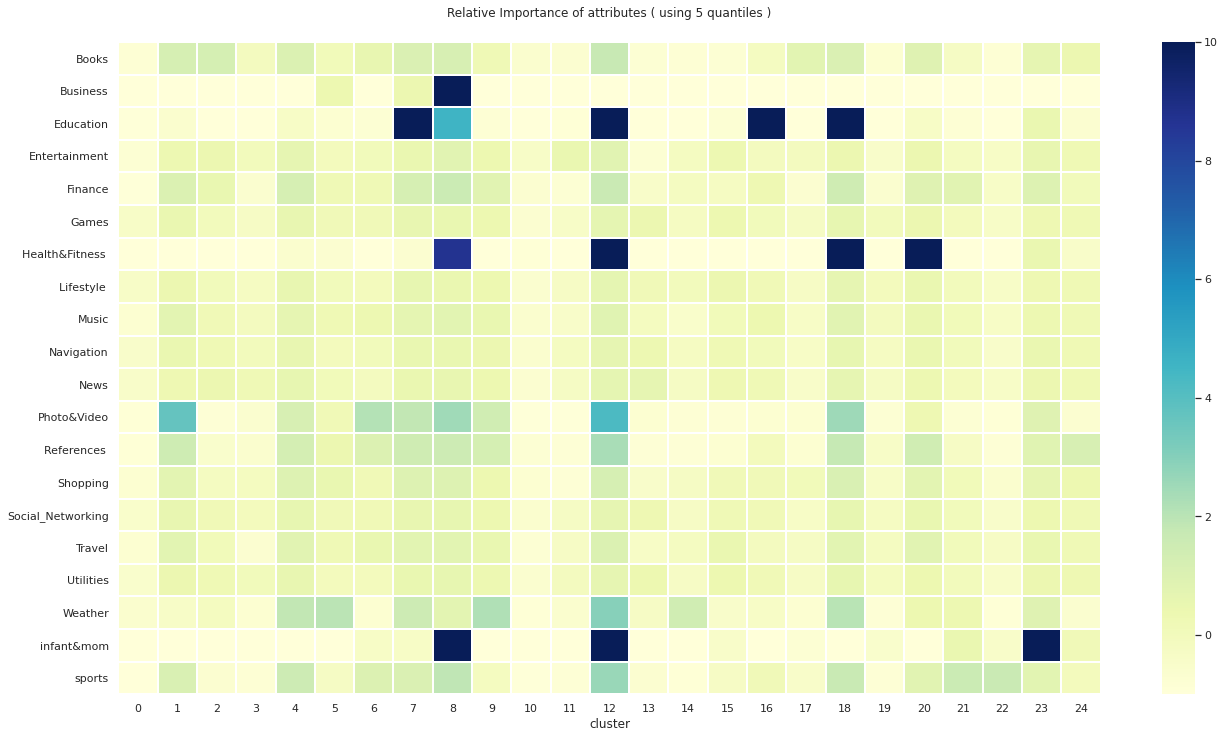

In [73]:
plt.figure(figsize=(22, 12))
ax = sns.heatmap(relative_importance.T, linewidths=1, cmap='YlGnBu', vmax=10)
ax.set_title(f"Relative Importance of attributes ( using {number_of_quantiles} quantiles )", pad=25)
image_directory = f'data/2_reports/S{sampling_period_in_hours}Q{number_of_quantiles}_{final_report_folder_name}/'
plt.savefig(image_directory + f'ClustersChart_K{best_k}_S{sampling_period_in_hours}Q{number_of_quantiles}.jpg')

In [74]:
clustering_data_selected_clusters['cluster'].value_counts()

10    94
0     77
4     70
19    64
3     47
1     46
17    46
11    44
9     37
22    36
21    35
15    35
24    35
6     31
5     30
7     29
14    25
2     20
13    19
20    14
23    13
16    12
18     6
8      5
12     1
Name: cluster, dtype: int64

# Save File

In [75]:
directory = f'data/2_reports/S{sampling_period_in_hours}Q{number_of_quantiles}_{final_report_folder_name}/'
directory

'data/2_reports/S6Q5_report_Dec2021/'

In [76]:
clustering_data_selected_clusters.to_csv(directory + f'CLUSTERING_K{best_k}_table_wide_format_S{sampling_period_in_hours}Q{number_of_quantiles}.csv',
                       sep=',',
                       encoding= 'utf-8',
                       index=True)


In [77]:
clustering_data_selected_clusters

,Books,Business,Education,Entertainment,Finance,Games,Health&Fitness,Lifestyle,Music,Navigation,News,Photo&Video,References,Shopping,Social_Networking,Travel,Utilities,Weather,infant&mom,sports,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
942,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,8
772,555,0,555,555,555,555,454,555,555,555,555,555,555,555,555,555,555,555,541,555,12
837,555,0,554,555,555,555,223,555,555,555,555,555,555,555,555,555,555,555,0,555,18
723,555,0,321,555,555,555,0,555,555,555,555,555,555,555,555,555,555,555,221,555,7
667,555,0,555,555,555,555,354,555,555,555,555,334,555,555,555,555,555,555,0,455,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,0,0,111,0,111,0,111,0,111,111,0,0,0,111,0,111,0,0,0,10
468,0,0,0,0,0,111,0,111,0,111,0,0,0,0,111,0,111,0,0,0,10
252,0,0,0,0,0,0,0,111,0,111,111,0,0,0,111,0,111,0,0,0,10
